In [1]:
import numpy as np
import scipy.special as special

import scipy.integrate as integrate

import matplotlib.pyplot as plt
import time

In [2]:
import sys

# append the path of the
# parent directory
sys.path.append('..')

In [3]:
def transducer_vec_kzk(a, d, c, freq, prop_loc=0, bpat_loc=0):
    k=2*np.pi*freq/c # Wave number
    R0=k*(a**2)/2 # Rayleigh distance
    G=R0/d # Focusing gain

    nrpts=200 # default 200, but runs much faster with 100
    nzpts=200 # default 200, 100 works too and is slightly less acurate

    rstart=-0.015 # change range as needed default -2*a
    rend=-rstart # change range as needed 2*a
    
    zstart=d/20 # avoid starting at z=0 where the KZK has a singularity
    zend=0.15 # up to what z distance to plot

    # Initialize empty pressure field with r and z axes
    r_axis = np.linspace(rstart, rend, nrpts)
    z_axis = np.linspace(zstart, zend, nzpts)

    # Integral solution from class notes
    # Set up integral function using function handle
    y = lambda x : special.j0(k*np.outer(r_axis, (1/z_axis))*x)*np.exp(-1j*(k/2)*(x**2)*((1/z_axis)-(1/d)))*x
    # Compute integral using special complex integral function we implemented.
    F = complex_quadrature_vec(y, 0, a) # scipy's integrate.quad does not provide complex values
    # Store value in pressure field
    p = abs(1j*(k/z_axis)*np.exp(-1j*k*np.outer((r_axis**2), 1/z_axis)/2)*F)

    pmax = np.max(p) # provide max value for normalization into dB scale
    lp=20*np.log10(p/pmax)

    nprop = int(nrpts*(prop_loc-rstart)/(rend-rstart)) # choose r = p_loc for propgation curve
    p_curve = p[nprop,:]

    nbpat = int(nzpts*(bpat_loc-zstart)/(zend-zstart)) #choose z = bpat_loc for beampattern
    bp_curve = p[:,nbpat]

    return z_axis, r_axis, p, p_curve, bp_curve

# Computes integral given complex values
def complex_quadrature_vec(func, a, b, **kwargs):
    def real_func(x):
        return np.real(func(x))
    def imag_func(x):
        return np.imag(func(x))
    real_integral = integrate.quad_vec(real_func, a, b, **kwargs)
    imag_integral = integrate.quad_vec(imag_func, a, b, **kwargs)
    return (real_integral[0] + 1j*imag_integral[0])

In [4]:
a=0.0127 # radius
d=0.091 # focus
freq=2.25e6
c=1500
b_loc = 0.05
p_loc = 0

start2 = time.time()
z2, r2, field2, pcurve2, bcurve2 = transducer_vec_kzk(a, d, c, freq, p_loc, b_loc)
duration2 = time.time() - start2
print(f'Time to do KZK integration using my vectorization-based method: {round(duration2, 3)}s')

Time to do KZK integration using my vectorization-based method: 3.95s


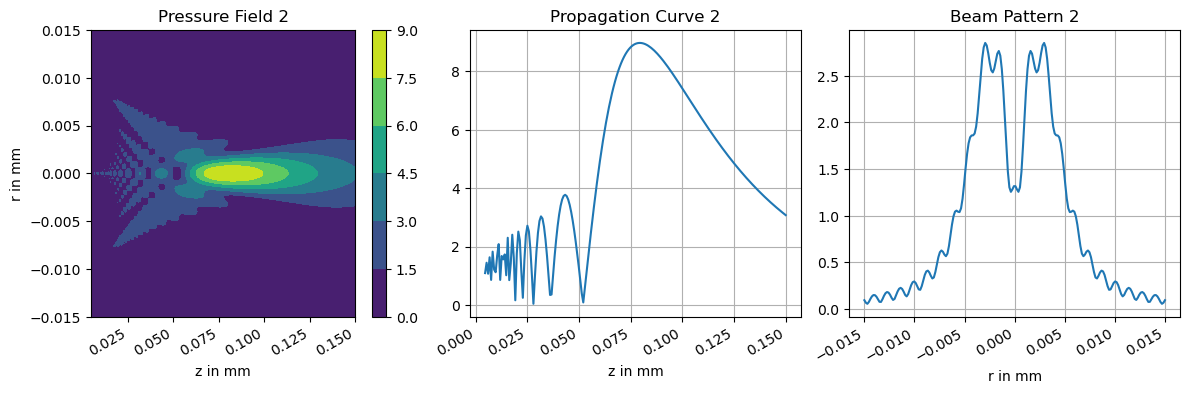

In [5]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.contourf(z2, r2, field2)
plt.colorbar()
plt.title('Pressure Field 2')
plt.ylabel("r in mm")
plt.xlabel("z in mm")

plt.subplot(132)
plt.plot(z2, pcurve2)
plt.title('Propagation Curve 2')
plt.grid(which='both')
plt.xlabel("z in mm")

plt.subplot(133)
plt.plot(r2, bcurve2)
plt.title('Beam Pattern 2')
plt.grid(which='both')
plt.xlabel("r in mm")
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()